In [1]:
import sys
sys.path.append("../src")

In [2]:
from utils.load_model import get_model

from my_model import get_ilsvrc2012

from torch.utils.data import DataLoader

from utils.imagenet1000_classname import imgnet_label_name
from utils.tensortracker import TensorTracker
from utils import plots

In [3]:
%matplotlib inline

In [4]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch.nn as nn

import svcca

In [5]:
from my_model import my_resnet

In [6]:
from glob import glob

In [7]:
plain_model = my_resnet.resnet34(pretrained=False, plain=True)
skip_model = my_resnet.resnet34(pretrained=False, plain=False)

In [8]:
root = "/data2/genta/resnet"

In [9]:
plain_paths = sorted(glob(os.path.join(root, '20200814*plain*', '*.model')))[:-2]
plain_paths = sorted(glob(os.path.join(root, '20200814*plain*', 'init.model'))) + plain_paths

In [10]:
skip_paths = sorted(glob(os.path.join(root, '20200814*resnet*', '*.model')))[:-2]
skip_paths = sorted(glob(os.path.join(root, '20200814*resnet*', 'init.model'))) + skip_paths

In [11]:
mode = "test"
test_dataset = get_ilsvrc2012(mode=mode, transform_type="test")
test_labels = np.asarray(test_dataset.targets)

index = []
for i in range(1000):
    idx = np.where(test_labels == i)[0][0]
    index.append(idx)
index = np.asarray(index)

device = "cuda"
N = 256
np.random.seed(815)
perm = np.random.permutation(len(index))
images = [test_dataset[i][0] for i in index[perm[:N]]]
images = torch.stack(images)
images = images.to(device)

In [12]:
plain_model = plain_model.to(device)
plain_model.eval()
tracker = TensorTracker(plain_model)
plain_model(images[:2])
keys_skip = tracker.fmap_pool.keys()

In [13]:
keys = np.asarray(list(keys_skip))
target_key = [np.where(keys == k)[0][0] for k in keys if "relu2" in k or "maxpool" == k]
cand_layers = keys[target_key].tolist()

In [14]:
cand_layers

['maxpool',
 'layer1.0.relu2',
 'layer1.1.relu2',
 'layer1.2.relu2',
 'layer2.0.relu2',
 'layer2.1.relu2',
 'layer2.2.relu2',
 'layer2.3.relu2',
 'layer3.0.relu2',
 'layer3.1.relu2',
 'layer3.2.relu2',
 'layer3.3.relu2',
 'layer3.4.relu2',
 'layer3.5.relu2',
 'layer4.0.relu2',
 'layer4.1.relu2',
 'layer4.2.relu2']

In [15]:
plain_paths[::10]

['/data2/genta/resnet/20200814_plainnet34-imagenet/init.model',
 '/data2/genta/resnet/20200814_plainnet34-imagenet/10.model',
 '/data2/genta/resnet/20200814_plainnet34-imagenet/20.model',
 '/data2/genta/resnet/20200814_plainnet34-imagenet/30.model',
 '/data2/genta/resnet/20200814_plainnet34-imagenet/40.model',
 '/data2/genta/resnet/20200814_plainnet34-imagenet/50.model',
 '/data2/genta/resnet/20200814_plainnet34-imagenet/60.model',
 '/data2/genta/resnet/20200814_plainnet34-imagenet/70.model',
 '/data2/genta/resnet/20200814_plainnet34-imagenet/80.model',
 '/data2/genta/resnet/20200814_plainnet34-imagenet/90.model']

In [16]:
p_tracker = TensorTracker(plain_model, candidate_layers=cand_layers)
s_tracker = TensorTracker(skip_model, candidate_layers=cand_layers)

In [17]:
model = plain_model
paths = plain_paths[::10]
tracker = p_tracker

datas = []
for path in tqdm(paths, total=len(paths)):
    name = os.path.basename(path)
    model.load_state_dict(my_resnet.fix_model_state_dict(torch.load(path)))
    model = model.eval()
    model = model.to(device)

    with torch.no_grad():
        out = model(images)
    data = []
    func = lambda x: (len(x) - np.count_nonzero(x)) / len(x)
    for l1 in keys[target_key]:
        act1 = tracker.find_fmap(l1).to('cpu').numpy()
        data.append(func(act1.reshape(-1)))
    data = np.asarray(data)
    datas.append(data)

datas = np.asarray(datas)

100%|██████████| 10/10 [01:02<00:00,  6.16s/it]


In [18]:
plain_datas = datas.copy()

In [19]:
datas.shape

(10, 17)

In [20]:
linestyles = [
    "solid",
    "dashed",
    "dotted"
]

In [21]:
# cmap = plt.get_cmap("viridis")
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
cmap = plt.get_cmap(cmaps[4])
colors = [cmap(i) for i in np.linspace(0, 1, len(datas))]
alpha = 0.7

In [22]:
data = plain_datas.copy()
out_name = "plain"

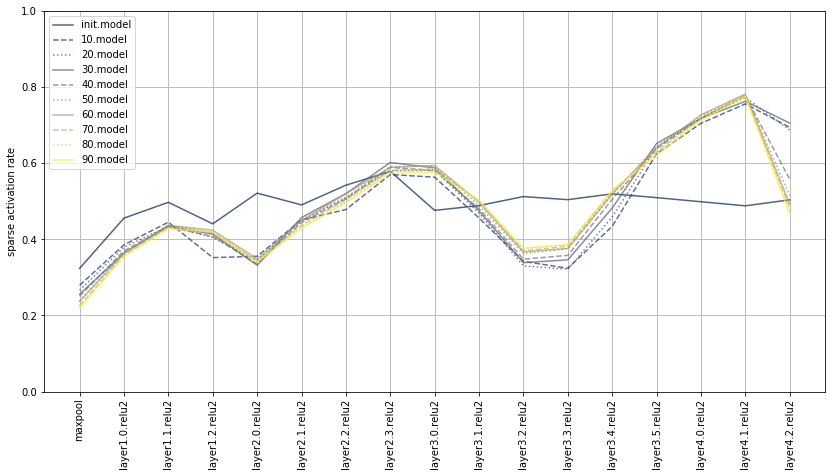

In [23]:

plt.figure(figsize=(14, 7))
color = "tab:blue"
label = "skip"
for cnt, d in enumerate(data):
    x = np.arange(len(d))
    name = os.path.basename(paths[cnt])
    plt.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)

plt.xticks(range(len(target_key)), keys[target_key], rotation=90)
plt.ylabel("sparse activation rate")
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.show()

In [24]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [25]:
fig, ax = plt.subplots(figsize=(14, 10))

ln, = ax.plot([])
def init():
    ax.set_xticks(range(len(target_key)))
    ax.set_xticklabels(keys[target_key], rotation=90)
    ax.set_ylabel("sparse activation rate")
    ax.set_ylim(0, 1)
    ax.grid()
    return ln,

def update(frame):
    ax.cla()
    init()
    cnt = frame
    d = data[cnt]
    x = np.arange(len(d))
    name = os.path.basename(paths[cnt])
    ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
    
    if len(data) > cnt + 1:
        cnt = cnt + 1
        d = data[cnt]
        x = np.arange(len(d))
        name = os.path.basename(paths[cnt])
        ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
 
    ax.legend(loc="upper left")
    return ln, 

ani = FuncAnimation(fig, update, frames=len(data),
                    init_func=init, blit=True, interval=50)
plt.close()
ani.save("{}.gif".format(out_name), writer="imagemagick", fps=5)
HTML(ani.to_jshtml())


In [26]:
model = skip_model
paths = skip_paths[::10]
tracker = s_tracker

datas = []
for path in tqdm(paths, total=len(paths)):
    name = os.path.basename(path)
    model.load_state_dict(my_resnet.fix_model_state_dict(torch.load(path)))
    model = model.eval()
    model = model.to(device)

    with torch.no_grad():
        out = model(images)
    data = []
    func = lambda x: (len(x) - np.count_nonzero(x)) / len(x)
    for l1 in keys[target_key]:
        act1 = tracker.find_fmap(l1).to('cpu').numpy()
        data.append(func(act1.reshape(-1)))
    data = np.asarray(data)
#     data = np.frompyfunc(lambda x: (len(x) - np.count_nonzero(x)) / len(x), 1, 1)(data)
    datas.append(data)

datas = np.asarray(datas)

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


In [27]:
skip_datas = datas.copy()

In [28]:
skip_datas.shape

(10, 17)

In [29]:
data = skip_datas.copy()

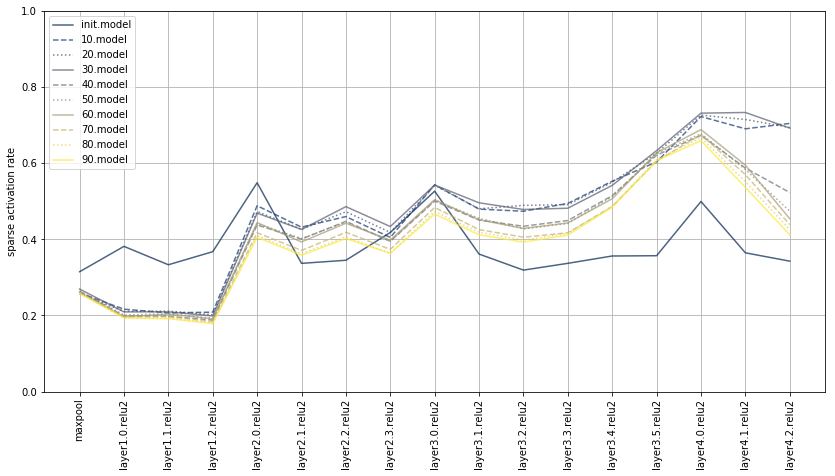

In [30]:

plt.figure(figsize=(14, 7))
color = "tab:blue"
label = "skip"
for cnt, d in enumerate(data):
    x = np.arange(len(d))
    name = os.path.basename(paths[cnt])
    plt.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)

plt.xticks(range(len(target_key)), keys[target_key], rotation=90)
plt.ylabel("sparse activation rate")
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.show()

In [31]:
data = skip_datas.copy()
out_name = "skip"

In [32]:
fig, ax = plt.subplots(figsize=(14, 10))

ln, = ax.plot([])
def init():
    ax.set_xticks(range(len(target_key)))
    ax.set_xticklabels(keys[target_key], rotation=90)
    ax.set_ylabel("sparse activation rate")
    ax.set_ylim(0, 1)
    ax.grid()
    return ln,

def update(frame):
    ax.cla()
    init()
    cnt = frame
    d = data[cnt]
    x = np.arange(len(d))
    name = os.path.basename(paths[cnt])
    ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
    
    if len(data) > cnt + 1:
        cnt = cnt + 1
        d = data[cnt]
        x = np.arange(len(d))
        name = os.path.basename(paths[cnt])
        ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
 
    ax.legend(loc="upper left")
    return ln, 

ani = FuncAnimation(fig, update, frames=len(data),
                    init_func=init, blit=True, interval=50)
plt.close()
ani.save("{}.gif".format(out_name), writer="imagemagick", fps=5)
HTML(ani.to_jshtml())


In [33]:
model = plain_model
paths = plain_paths[:10]
tracker = p_tracker

datas = []
for path in tqdm(paths, total=len(paths)):
    name = os.path.basename(path)
    model.load_state_dict(my_resnet.fix_model_state_dict(torch.load(path)))
    model = model.eval()
    model = model.to(device)

    with torch.no_grad():
        out = model(images)
    data = []
    func = lambda x: (len(x) - np.count_nonzero(x)) / len(x)
    for l1 in keys[target_key]:
        act1 = tracker.find_fmap(l1).to('cpu').numpy()
        data.append(func(act1.reshape(-1)))
    data = np.asarray(data)
#     data = np.frompyfunc(lambda x: (len(x) - np.count_nonzero(x)) / len(x), 1, 1)(data)
    datas.append(data)

datas = np.asarray(datas)

100%|██████████| 10/10 [01:01<00:00,  6.17s/it]


In [34]:
plain10_datas = datas.copy()

In [41]:
model = skip_model
paths = skip_paths[:10]
tracker = s_tracker
datas = []
for path in tqdm(paths, total=len(paths)):
    name = os.path.basename(path)
    model.load_state_dict(my_resnet.fix_model_state_dict(torch.load(path)))
    model = model.eval()
    model = model.to(device)

    with torch.no_grad():
        out = model(images)
    data = []
    func = lambda x: (len(x) - np.count_nonzero(x)) / len(x)
    for l1 in keys[target_key]:
        act1 = tracker.find_fmap(l1).to('cpu').numpy()
        data.append(func(act1.reshape(-1)))
    data = np.asarray(data)
#     data = np.frompyfunc(lambda x: (len(x) - np.count_nonzero(x)) / len(x), 1, 1)(data)
    datas.append(data)

datas = np.asarray(datas)

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


In [42]:
skip10_datas = datas.copy()

In [43]:
out_name = "skip10"
data = skip10_datas.copy()

In [44]:
fig, ax = plt.subplots(figsize=(14, 10))

ln, = ax.plot([])
def init():
    ax.set_xticks(range(len(target_key)))
    ax.set_xticklabels(keys[target_key], rotation=90)
    ax.set_ylabel("sparse activation rate")
    ax.set_ylim(0, 1)
    ax.grid()
    return ln,

def update(frame):
    ax.cla()
    init()
    cnt = frame
    d = data[cnt]
    x = np.arange(len(d))
    name = os.path.basename(paths[cnt])
    ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
    
    if len(data) > cnt + 1:
        cnt = cnt + 1
        d = data[cnt]
        x = np.arange(len(d))
        name = os.path.basename(paths[cnt])
        ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
 
    ax.legend(loc="upper left")
    return ln, 

ani = FuncAnimation(fig, update, frames=len(data),
                    init_func=init, blit=True, interval=50)
plt.close()
ani.save("{}.gif".format(out_name), writer="imagemagick", fps=5)
HTML(ani.to_jshtml())


In [39]:
out_name = "plain10"
data = plain10_datas.copy()

In [40]:
fig, ax = plt.subplots(figsize=(14, 10))

ln, = ax.plot([])
def init():
    ax.set_xticks(range(len(target_key)))
    ax.set_xticklabels(keys[target_key], rotation=90)
    ax.set_ylabel("sparse activation rate")
    ax.set_ylim(0, 1)
    ax.grid()
    return ln,

def update(frame):
    ax.cla()
    init()
    cnt = frame
    d = data[cnt]
    x = np.arange(len(d))
    name = os.path.basename(paths[cnt])
    ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
    
    if len(data) > cnt + 1:
        cnt = cnt + 1
        d = data[cnt]
        x = np.arange(len(d))
        name = os.path.basename(paths[cnt])
        ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
 
    ax.legend(loc="upper left")
    return ln, 

ani = FuncAnimation(fig, update, frames=len(data),
                    init_func=init, blit=True, interval=50)
plt.close()
ani.save("{}.gif".format(out_name), writer="imagemagick", fps=5)
HTML(ani.to_jshtml())


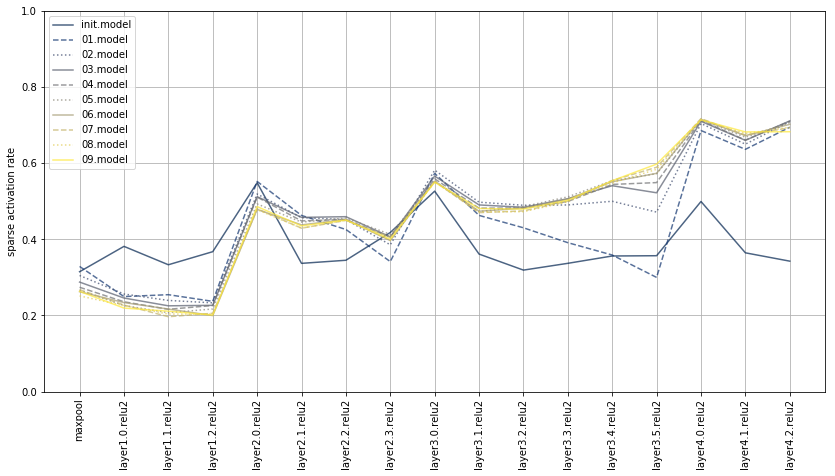

In [46]:
data = skip10_datas.copy()

plt.figure(figsize=(14, 7))
color = "tab:blue"
label = "skip"
for cnt, d in enumerate(data):
    x = np.arange(len(d))
    name = os.path.basename(paths[cnt])
    plt.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)

plt.xticks(range(len(target_key)), keys[target_key], rotation=90)
plt.ylabel("sparse activation rate")
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.show()

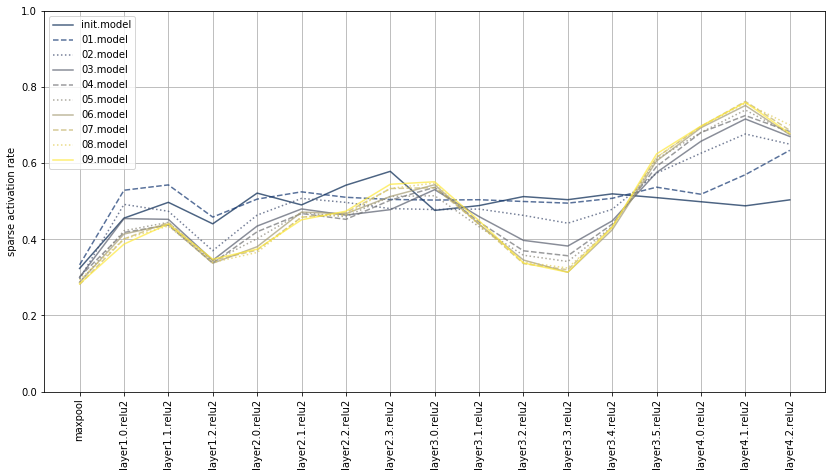

In [45]:
data = plain10_datas.copy()

plt.figure(figsize=(14, 7))
color = "tab:blue"
label = "skip"
for cnt, d in enumerate(data):
    x = np.arange(len(d))
    name = os.path.basename(paths[cnt])
    plt.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)

plt.xticks(range(len(target_key)), keys[target_key], rotation=90)
plt.ylabel("sparse activation rate")
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.show()

In [47]:
paths = skip_paths[:10] + skip_paths[::10][1:]
out_name = "skip_"
data = np.concatenate((skip10_datas.copy(), skip_datas.copy()[1:]))

In [50]:
# cmap = plt.get_cmap("viridis")
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
cmap = plt.get_cmap(cmaps[4])
colors = [cmap(i) for i in np.linspace(0, 1, len(data))]
alpha = 0.7

In [51]:
fig, ax = plt.subplots(figsize=(14, 10))

ln, = ax.plot([])
def init():
    ax.set_xticks(range(len(target_key)))
    ax.set_xticklabels(keys[target_key], rotation=90)
    ax.set_ylabel("sparse activation rate")
    ax.set_ylim(0, 1)
    ax.grid()
    return ln,

def update(frame):
    ax.cla()
    init()
    cnt = frame
    d = data[cnt]
    x = np.arange(len(d))
    name = os.path.basename(paths[cnt])
    ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
    
    if len(data) > cnt + 1:
        cnt = cnt + 1
        d = data[cnt]
        x = np.arange(len(d))
        name = os.path.basename(paths[cnt])
        ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
 
    ax.legend(loc="upper left")
    return ln, 

ani = FuncAnimation(fig, update, frames=len(data),
                    init_func=init, blit=True, interval=50)
plt.close()
ani.save("{}.gif".format(out_name), writer="imagemagick", fps=5)
HTML(ani.to_jshtml())


In [52]:
paths = plain_paths[:10] + plain_paths[::10][1:]
out_name = "plain_"
data = np.concatenate((plain10_datas.copy(), plain_datas.copy()[1:]))

In [53]:
fig, ax = plt.subplots(figsize=(14, 10))

ln, = ax.plot([])
def init():
    ax.set_xticks(range(len(target_key)))
    ax.set_xticklabels(keys[target_key], rotation=90)
    ax.set_ylabel("sparse activation rate")
    ax.set_ylim(0, 1)
    ax.grid()
    return ln,

def update(frame):
    ax.cla()
    init()
    cnt = frame
    d = data[cnt]
    x = np.arange(len(d))
    name = os.path.basename(paths[cnt])
    ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
    
    if len(data) > cnt + 1:
        cnt = cnt + 1
        d = data[cnt]
        x = np.arange(len(d))
        name = os.path.basename(paths[cnt])
        ax.plot(x, d, linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)
 
    ax.legend(loc="upper left")
    return ln, 

ani = FuncAnimation(fig, update, frames=len(data),
                    init_func=init, blit=True, interval=50)
plt.close()
ani.save("{}.gif".format(out_name), writer="imagemagick", fps=5)
HTML(ani.to_jshtml())
